# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import tree
from sklearn.cluster import KMeans
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import time

C:\Users\avinash\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [28]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [29]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [30]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [31]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [32]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [33]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [34]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [35]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [36]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [37]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [38]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [39]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [40]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [41]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [42]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [43]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [44]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [45]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [46]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [47]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:01<00:00, 2860.55it/s]


In [48]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [49]:
#############---- storing the data into .sqlite file ------########################
final['cleaned_text'] = preprocessed_reviews #adding a column of cleaned_text which displays the data after pre-processing of the 
                                                                                                                #review 
#final['cleaned_text']=final['cleaned_text'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
            index=True, index_label=None, chunksize=None, dtype=None)
#conn.close()

In [50]:
#Function to count no. of unique values in variable of any datatype.
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T

In [51]:
unique_label_count = unique_count(final['Score'].values)
unique_label_count

array([[     0,  54744],
       [     1, 293516]], dtype=int64)

In [52]:
#To find out the class ratio.
class_ratio = unique_label_count[1,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 1 = {}%'.format(class_ratio))

class_ratio for Class 1 = 0.842807098145064%


In [53]:
#To find out the class ratio.
class_ratio = unique_label_count[0,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 2 = {}%'.format(class_ratio))

class_ratio for Class 2 = 0.15719290185493598%


In [54]:
#Taking 30k * 0.8428 positive reviews from cleaned SQLlite table final.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 1
--ORDER BY RANDOM()
LIMIT 25284;
""", conn)

positive_reviews = display
positive_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
1,138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...


In [55]:
#Taking 30k * 0.15720 negative reviews from cleaned SQLlite table final.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 0
--ORDER BY RANDOM()
LIMIT 4716;
""", conn)

negative_reviews = display
negative_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
1,138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,give five stars maurice sendak story one star ...


In [46]:
#Combining postive reviews and negative reviews
final30k = []
final30k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final30k = final30k.sort_values('Time',ascending=True)
final30k.tail(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
1342,441646,477560,B000084ETY,A1HRYC60VTMYC0,Ace,0,0,1,1351209600,"Cee Cee LOOOVES it, This I Know",The only reason I am giving it 4 stars instead...,reason giving stars instead stars strange desi...
25762,307489,333012,B0000CFXYA,A3GS4GWPIBV0NT,"R. Chester ""ricki1966""",0,0,0,1351209600,Strange inflammation response,Truthfully wasn't crazy about the taste of the...,truthfully not crazy taste reason low rating p...
15025,479530,518539,B0002YW26E,A506HOOCVL8GW,"J. Kurz ""J. Q. Public""",0,0,1,1351209600,You won't believe what you'll catch!,I have been using this product for many years....,using product many years great non poisonous m...
20486,328309,355352,B0007PNKRS,A1TED4G0PWZPQV,Stellavera S. Kilcher,0,0,1,1351209600,Came as expected,It was tasty and fresh. The other one I bought...,tasty fresh one bought old tasted moldy one good
9952,210831,228526,B0001M0ZWA,AUEA2NJHMK9DF,"Penny E. Cooke ""PMSDEA""",0,0,1,1351209600,Like this tea,This tea has a nice flavor although I wish it ...,tea nice flavor although wish little stronger ...


In [47]:
X_train = final30k['cleaned_text'].values

In [2]:
#Function to pickle in an object:
def openPickleFile(name): #name = the pickle file name, this should be passed as a string inside " ".
    global temp
    temp = pickle.load(open(name + ".pickle","rb"))
    return temp

#Function to pickle out an object.
def savePickleFile(obj,name):
    pickle.dump(obj, open(name + ".pickle","wb"))

In [57]:
#To pickle-out/save an object.
savePickleFile(X_train, "X_train")

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [58]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [63]:
openPickleFile("X_train")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(30000,)
object


In [72]:
X_train_preprocessed = X_train #Preprocessed train data will be used later.

## [4.3] TF-IDF

**Vectorization of X_train**

In [65]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, use_idf=True)
tf_idf_fit = tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_fit.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ab', 'abdominal', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 17927)
the number of unique words including both unigrams and bigrams  17927


In [66]:
standardized_tfidf_train = MaxAbsScaler().fit_transform(final_tf_idf_train)
standardized_tfidf_train

<30000x17927 sparse matrix of type '<class 'numpy.float64'>'
	with 1211640 stored elements in Compressed Sparse Row format>

In [54]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_train, "X_train_TFIDF_sparse")

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [67]:
features = tf_idf_fit.get_feature_names()
np.shape(features)

(17927,)

In [68]:
np.argsort(tf_idf_fit.idf_)

array([10268,  8330,  6405, ..., 11560, 11606,     0], dtype=int64)

In [69]:
#Taking top 3000 features using idf scores of all features.
top_features = [features[i] for i in np.argsort(tf_idf_fit.idf_)[:3000]]
top_features[0:10]

['not',
 'like',
 'good',
 'great',
 'one',
 'product',
 'would',
 'taste',
 'love',
 'get']

### [5.2] Calulation of Co-occurrence matrix

In [70]:
X_train_preprocessed = [X_train_preprocessed[i].split() for i in range(len(X_train_preprocessed))]

In [73]:
# Initializing Co occurence matrix
cooc_matrix = np.array([[0 for i in range(len(top_features))] for i in range(len(top_features))])

#Creating a DataFrame taking cooc_matrix and top_features as columns names and row names.
cooc_Frame = pd.DataFrame(cooc_matrix, columns = top_features, index = top_features)

#Calculating Co-occurence matrix.
for sent in X_train_preprocessed:
    
    words = sent.split()
    for i in range(len(words)):
        for j in range(6): #for checking within a context window of 5.
            if(i + j < len(words) and words[i] != words[j+i]):
                try:
                    cooc_Frame.loc[words[i], words[j+i]] += 1 #If word for index i and j occur in a range of 6 words 
                                                              #add +1 to matrix for word i.
                    cooc_Frame.loc[words[j+i], words[i]] += 1 # Same logic as above for word for index j.
                except:
                    pass

In [74]:
cooc_Frame.head()

,not,like,good,great,one,product,would,taste,love,get,...,mg,medicinals,delicious not,fussy,sushi,two bags,exercise,managed,sodas,drink coffee
not,0,3894,2383,1391,1928,1875,2603,2401,1013,1834,...,19,6,0,23,12,0,19,18,23,0
like,3894,0,734,490,710,474,770,1446,383,429,...,2,15,0,2,14,0,3,2,13,0
good,2383,734,0,469,520,694,550,785,284,353,...,3,3,0,4,9,0,4,3,3,0
great,1391,490,469,0,387,1063,375,698,444,356,...,2,5,0,2,13,0,11,1,3,0
one,1928,710,520,387,0,337,550,354,351,452,...,9,1,0,9,8,0,2,12,8,0


### [5.3] Finding optimal value for number of components (n) to be retained.

In [50]:
# Create and run an TSVD with one less than number of features.
tsvd = TruncatedSVD(n_components=(cooc_Frame.shape[1]-1))
tsvd.fit_transform(cooc_Frame)

array([[ 9.60091787e+03,  5.68096774e+03, -8.44012580e+01, ...,
         1.21345989e-43, -2.00791851e-43,  2.39402691e-43],
       [ 4.90489483e+03, -1.80777968e+03, -5.56322053e+02, ...,
        -1.18944151e-43,  1.98245358e-42,  4.19427409e-43],
       [ 3.65396715e+03, -7.29071802e+02, -2.49964612e+02, ...,
        -2.66791073e-42,  2.34409538e-42, -1.11105695e-42],
       ...,
       [ 7.96221442e+01, -3.15139237e+01,  1.83411808e+01, ...,
         1.79741274e-41, -3.03459614e-41,  1.23084699e-41],
       [ 8.31388285e+01, -2.88723485e+01, -1.79814952e+00, ...,
         6.84650743e-42,  7.18028529e-42,  4.80774253e-42],
       [ 9.15997316e+01, -6.20403437e+00, -3.34952979e+00, ...,
         1.68582089e-41,  1.95417039e-41, -1.46947428e-41]])

In [51]:
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [52]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    global cumulative_explained_variance
    cumulative_explained_variance = []
    # Set initial number of features
    global n_components
    n_components = 0
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        cumulative_explained_variance.append(total_variance)
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [88]:
# To get optimal number of components required to preserve 0.99 explained variance.
select_n_components(tsvd_var_ratios, 0.99)

161

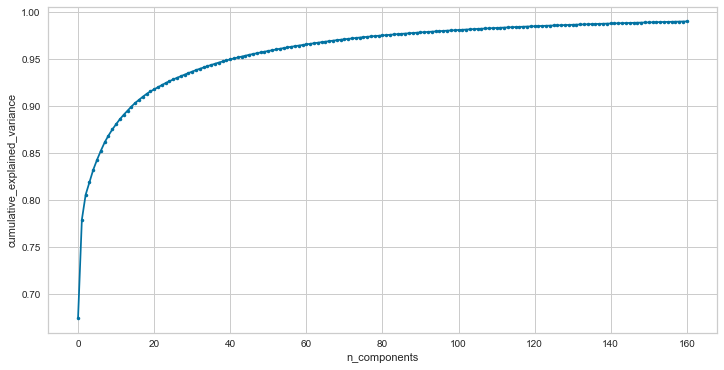

In [89]:
plt.figure(figsize=(12,6))
plt.xlabel('n_components')
plt.ylabel('cumulative_explained_variance')
plt.plot( range(n_components), cumulative_explained_variance, marker = "." )

In [90]:
optimal_components = select_n_components(tsvd_var_ratios, 0.99)
cooc_matrix_tsvd = TruncatedSVD(n_components=(optimal_components)).fit_transform(cooc_Frame)

In [91]:
cooc_matrix_frame = pd.DataFrame(cooc_matrix_tsvd, index = None) #Creating a dataframe for X_train_tsvd.
cooc_matrix_frame['features'] = top_features

In [92]:
cooc_matrix_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,features
0,9662.984942,5705.652344,-80.455013,-34.597028,-41.426458,16.218971,-211.705679,58.689304,-251.351789,-204.733807,...,-2.234190,-1.003388,1.610947,1.746098,0.301263,0.569971,0.006760,1.881487,-1.208358,not
1,4922.479236,-1803.772743,-558.255469,-425.106570,-926.930762,358.321780,-242.193208,760.301053,-257.205661,-140.610319,...,-4.266067,0.782556,2.910574,1.268179,-3.318169,1.056773,-1.368968,0.424996,11.100383,like
2,3665.615023,-728.302436,-251.870025,-14.469234,-523.943396,199.139379,-232.680360,243.291232,-73.476877,196.572312,...,5.278342,0.666330,-3.157492,-0.070054,3.111224,-5.307114,-7.266879,8.312275,1.807978,good
3,2966.474689,-44.025815,-93.378436,89.049107,-585.631234,276.624356,-198.805654,344.032010,277.916814,486.002949,...,-7.076332,2.533093,4.541150,-0.890584,-9.410814,7.493852,2.852485,-5.542196,-3.445744,great
4,3359.666036,-418.217523,169.149277,72.939409,171.165743,74.756573,453.835159,-57.040250,73.396258,-159.963225,...,0.055927,-2.800457,0.705932,10.216797,2.020783,2.218036,-6.857761,4.418770,-1.521017,one


### [5.4] Applying k-means clustering

In [96]:
time_start = time.time()
cluster_errors_tfidf = []
cluster_range = range(2,9,1)
for num_clusters in cluster_range:
  clusters_tfidf = KMeans(num_clusters, n_jobs=6)
  clusters_tfidf.fit(cooc_matrix_tsvd) #fitting KMeans on tsvd dimension reduced coocmatrix.
  cluster_errors_tfidf.append(clusters_tfidf.inertia_)

print ('Clustering for TFIDF for varying n_clusters done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for TFIDF for varying n_clusters done! Time elapsed: 2.6205523014068604 seconds


In [97]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors_tfidf } )

**Elbow curve to get the optimal k**

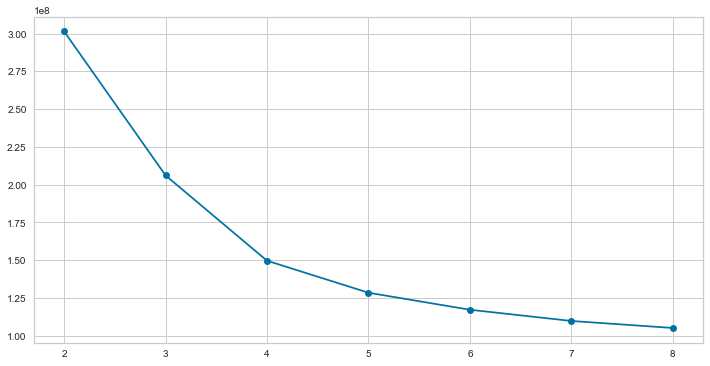

In [98]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [100]:
time_start = time.time()
optimal_k = min(zip(cluster_errors_tfidf, cluster_range))[1]
cluster_model_optimal_tfidf = KMeans(optimal_k, n_jobs=6).fit(cooc_matrix_tsvd)
print ('Clustering for TFIDF for optimal_k done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for TFIDF for optimal_k done! Time elapsed: 0.4657552242279053 seconds


**Intercluster Distance Maps**

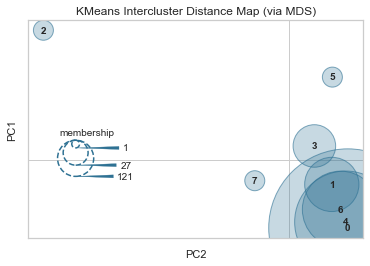

In [101]:
#To visialize the clusters in terms of inter and intra cluster distances.
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering mod3el and visualizer
visualizer = InterclusterDistance(KMeans(optimal_k))

visualizer.fit(cooc_matrix_tsvd) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### [5.5] Wordclouds of clusters obtained in the above section

In [106]:
def wordcloud_per_cluster(X_train, cluster_model_optimal, X_train_preprocessed):
    pred_labels = cluster_model_optimal.predict(X_train)#Getting the predicted labels for every datapoint.
    words_clusterwise = []
    for label in np.unique(cluster_model_optimal.labels_):
        words_clusterwise = [X_train_preprocessed[i].split() for i in range(X_train.shape[0]) if label == pred_labels[i]]
        #words_clusterwise_text = words_clusterwise_text + " " + str(words_clusterwise)
        wordcloud = WordCloud(width = 800, height = 800,
                    max_words = 100,
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate(str(words_clusterwise)) 
  
        # plot the WordCloud image                        
        plt.figure(figsize = (5, 5), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title("Cluster "+str(label))
      
        plt.show() 

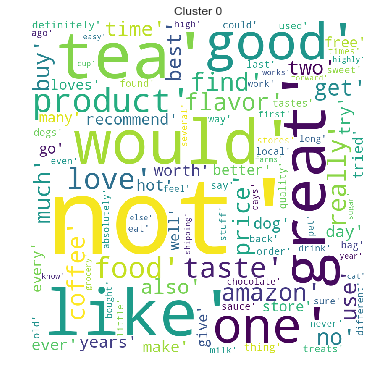

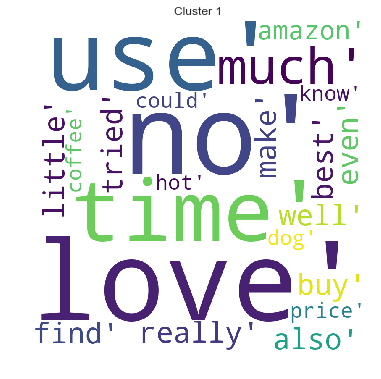

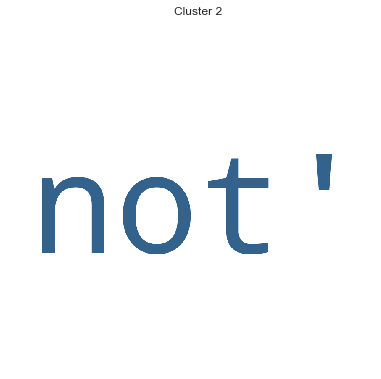

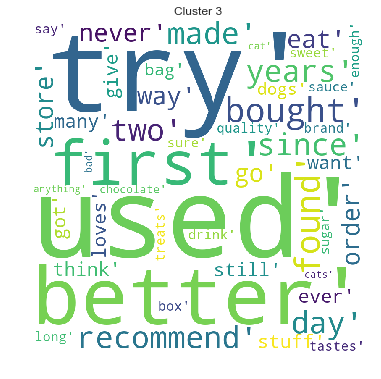

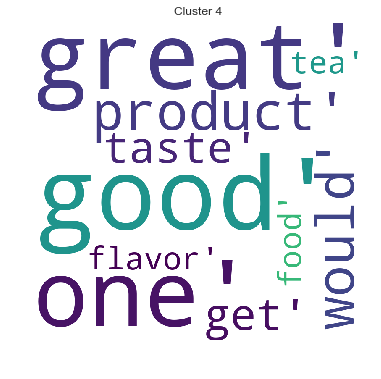

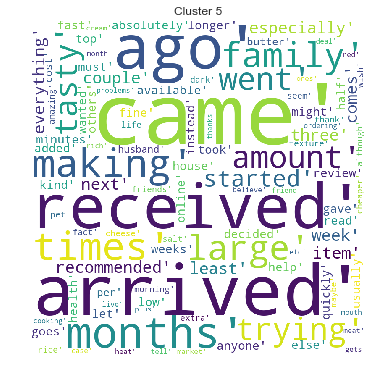

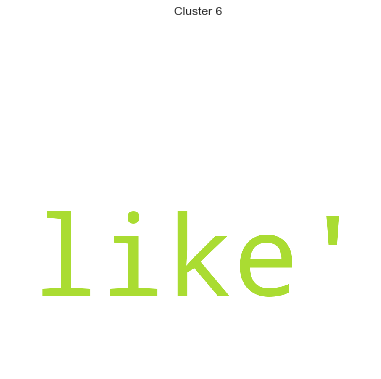

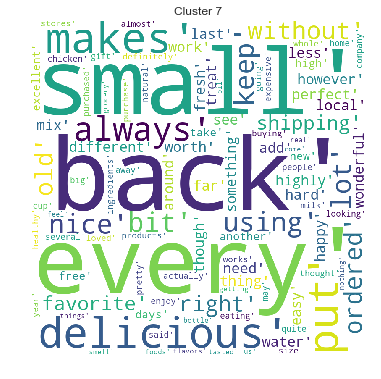

In [107]:
wordcloud_per_cluster(cooc_matrix_tsvd, cluster_model_optimal_tfidf, top_features)

### [5.6] Function that returns most similar words for a given word.

In [176]:
# Please write all the code with proper documentation
from sklearn.metrics.pairwise import cosine_similarity
def top_similarWords(word, dataframe, topn):
    match_frame =dataframe[dataframe['features'].str.match(word)]
    vec = match_frame.drop(['features'], axis = 1)
    words = dataframe['features']
    framez = dataframe.drop(['features'], axis = 1)
    similarity_Vec = cosine_similarity(vec, framez)
    #sorting the similarity vector and words for desc cosine-similariyt
    top_similar_words = sorted(zip(similarity_Vec[0], words), reverse=True)[:topn]
    print('\tCosine Similarity\t\tWords')
    print('\t-----------------\t\t-----')
    for cosine_sim, word in top_similar_words:
        print('\t{}\t\t{}'.format(cosine_sim, word))
        #return

In [177]:
#Fetching top20 similar words with cosine similarity.
top_similarWords('waste', cooc_matrix_frame, 20)

	Cosine Similarity		Words
	-----------------		-----
	1.0000000000000004		waste
	0.9505599313391527		wasted
	0.8328685873317245		save
	0.8189849306962078		spend
	0.8174530473270684		unless
	0.8123695964409101		spending
	0.8102112217224589		mention
	0.80725857115716		care
	0.8071005538316397		know
	0.805808156581428		believe
	0.8056030760733407		bother
	0.8049561786289918		understand
	0.8027912741589934		either
	0.8022383975389178		disappointed
	0.7961644621688637		bad
	0.7961052737766066		obviously
	0.79139721117829		return
	0.7909119542093106		realize
	0.7908592305197469		mind
	0.7903605162468181		worry


# [6] Conclusions

1. Optimal number of components required to retain 99% of Cooccurence matrix is 162.
2. Optimal number of clusters for K-means is 8 .
3. Cosine similarity for word 'waste' is calculated and 'wasted' was found to be most similar word.